## Charge the libraries

In [1]:
# Automatically reload modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Import standard libraries
import os
import sys

# Import third-party libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    classification_report,
)
import matplotlib.pyplot as plt

## Functions to use in the code

In [3]:
def result_metrics(cm):
    """
    Calculate sensitivity, specificity and accuracy from a confusion matrix.
    
    Parameters:
    - cm: array-like of shape (2, 2)
            Confusion matrix with format:
            [[TN, FP],
            [FN, TP]]
    
    Returns:
    - sensitivity: Also known as recall or true positive rate (float)
    - specificity: Also known as true negative rate (float)
    - accuracy: Overall accuracy of the model (float)
    """
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    # Return the calculated metrics
    return sensitivity, specificity, accuracy

In [4]:
def plot_roc_curve(y_test, y_prob, model_name="Model", figsize=(8, 6)):
    """
    Plot ROC curve for a single classification model.
    
    Parameters:
    - y_test: True target values for the test set (array-like)
    - y_prob: Prediction probabilities for the positive class (array-like)
    - model_name: Name of the model to display in the plot (str, optional)
    - figsize: Figure size (width, height) in inches (tuple, optional)
    
    Returns:
    - auc_score: Area Under the ROC Curve score (float)
    """
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    
    # Create plot
    plt.figure(figsize=figsize)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.3f})", linewidth=2)
    
    # Add diagonal line representing random chance
    plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
    
    # Add labels and title
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve: {model_name}")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    
    # Set axes limits
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    
    plt.tight_layout()
    plt.show()
    
    return auc_score

In [5]:
def plot_confusion_matrix(y_test, y_pred, model_name="Model", figsize=(6, 5)):
    """
    Plot confusion matrix for a classification model and return the confusion matrix.
    
    Parameters:
    - y_test: True target values for the test set (array-like)
    - y_pred: Predicted class labels (array-like)
    - model_name: Name of the model to display in the plot (str, optional)
    - figsize: Figure size (width, height) in inches (tuple, optional)
    
    Returns:
    - cm: Confusion matrix [[TN, FP], [FN, TP]] (array, shape (2, 2))
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Create plot
    plt.figure(figsize=figsize)
    
    # Plot confusion matrix as heatmap
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: {model_name}")
    
    # Add colorbar
    plt.colorbar()
    
    # Add text annotations
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    # Set labels and ticks
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks([0, 1], ['Negative (0)', 'Positive (1)'])
    plt.yticks([0, 1], ['Negative (0)', 'Positive (1)'])
    
    plt.tight_layout()
    plt.show()
    
    return cm

## Charge the dataset

In [6]:
# Attempt to load the Default dataset
default_data_available = False

# Try to load the dataset from a local file
try:
    print("Loading Default dataset from local file")

    # Path to the Default dataset
    default_path = os.path.join(os.getcwd(), "datasets", "Default.csv")

    # Read the dataset from the specified path
    raw_df = pd.read_csv(default_path, sep=",", index_col=0)

    # Preprocess the dataset
    # Transform categorical variables to numerical values ('default', 'student') to 0 and 1
    raw_df['default'] = raw_df['default'].map({'No': 0, 'Yes': 1})
    raw_df['student'] = raw_df['student'].map({'No': 0, 'Yes': 1})

    # Define the target variable and features
    features = ['balance', 'income']
    target = 'default'
    
    # Split the dataset into features and target variable
    X = raw_df[features]
    y = raw_df[target]

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Set the flag to indicate that the dataset is available
    default_data_available = True
    print("Default dataset loaded successfully.")

except Exception as e:
    print(f"Error loading Default dataset: {e}")
    print("Cannot proceed without the dataset. Please check the local file path.")
    print("Note: The Default dataset hasn't been provided in the repository.")

Loading Default dataset from local file
Default dataset loaded successfully.


## Explore the data Structure

GENERAL DATA EXPLORATION

First 5 rows of the dataset:
   default  student      balance        income
1        0        0   729.526495  44361.625074
2        0        1   817.180407  12106.134700
3        0        0  1073.549164  31767.138947
4        0        0   529.250605  35704.493935
5        0        0   785.655883  38463.495879

Dataset information (columns, data types, non-null counts):
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  int64  
 1   student  10000 non-null  int64  
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 390.6 KB

Check for any missing values:
default    0
student    0
balance    0
income     0
dtype: int64

Statistics for numerical columns in complete dataset:
            default       student       balance        income
count 

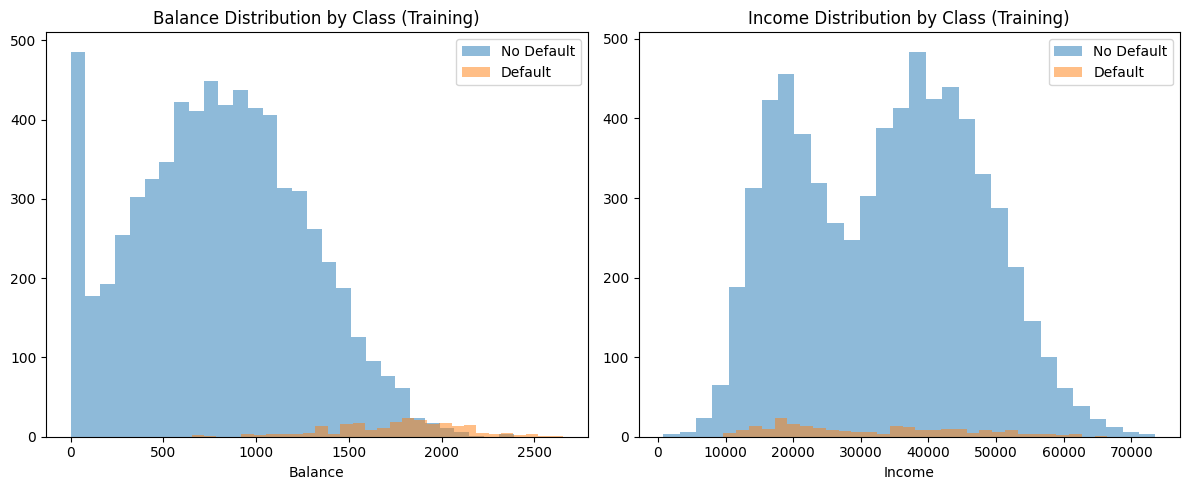



TEST SET ANALYSIS

Test set shape: (3000, 3)

Descriptive statistics for test set:
           balance        income      default
count  3000.000000   3000.000000  3000.000000
mean    835.921487  33300.632095     0.031333
std     478.412734  13107.169424     0.174246
min       0.000000   1498.227274     0.000000
25%     483.077898  21575.042890     0.000000
50%     831.416377  34246.811449     0.000000
75%    1170.205387  43310.045170     0.000000
max    2391.007739  69342.672480     1.000000

Class distribution in test set:
default
0    2906
1      94
Name: count, dtype: int64
Percentage:
default
0    96.866667
1     3.133333
Name: proportion, dtype: float64

Correlation matrix for test set:
          balance    income   default
balance  1.000000 -0.146009  0.323424
income  -0.146009  1.000000  0.001476
default  0.323424  0.001476  1.000000


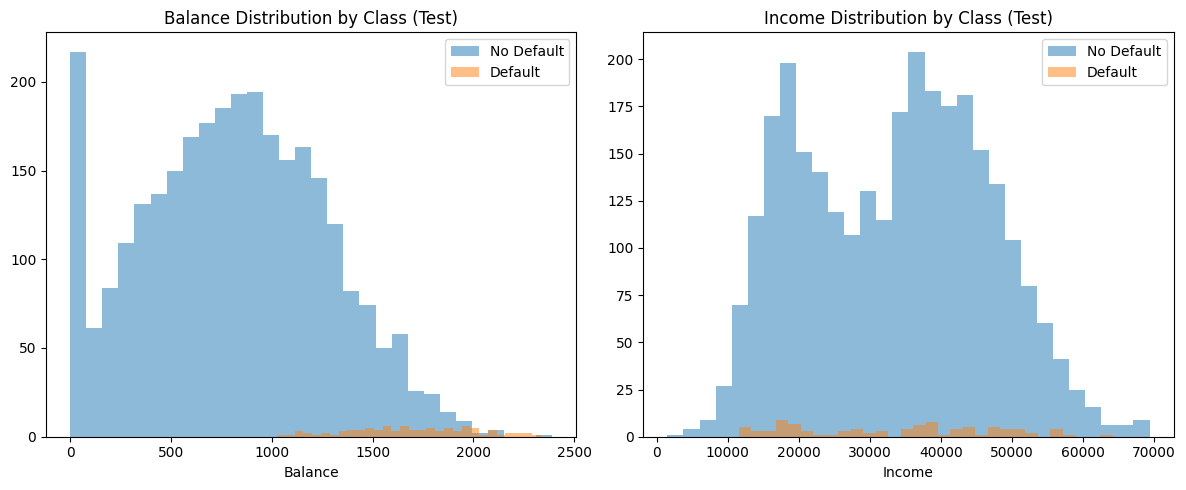



COMPARISON BETWEEN TRAIN AND TEST SETS

Mean values comparison:
                Train          Test
balance    835.140628    835.921487
income   33609.703210  33300.632095
default      0.034143      0.031333

Standard deviation comparison:
                Train          Test
balance    486.003447    478.412734
income   13433.644701  13107.169424
default      0.181609      0.174246


In [10]:
# Analyze both training and test datasets
try:
    if default_data_available and raw_df is not None:
        # General dataset exploration
        print("GENERAL DATA EXPLORATION")
        print("===================================")
        print("\nFirst 5 rows of the dataset:")
        print(raw_df.head())

        # Provide information of the DataFrame
        print("\nDataset information (columns, data types, non-null counts):")
        print("===================================")
        raw_df.info()

        # Check for missing values
        print("\nCheck for any missing values:")
        print("===================================")
        print(raw_df.isnull().sum())

        # Descriptive statistics for the complete dataset
        print("\nStatistics for numerical columns in complete dataset:")
        print("===================================")
        print(raw_df.describe())
        
        # Class distribution in the target variable
        print("\nDistribution of default values (0: No default, 1: Default):")
        print("===================================")
        print(raw_df['default'].value_counts())
        print("Percentage:")
        print(raw_df['default'].value_counts(normalize=True) * 100)
        
        # TRAINING SET ANALYSIS
        print("\n\nTRAINING SET ANALYSIS")
        print("===================================")
        
        # Create a DataFrame for the training set
        train_df = pd.concat([X_train, y_train], axis=1)
        
        # Show training set size and statistics
        print(f"\nTraining set shape: {train_df.shape}")
        print("\nDescriptive statistics for training set:")
        print(train_df.describe())
        
        # Class distribution in training set
        print("\nClass distribution in training set:")
        print(train_df['default'].value_counts())
        print("Percentage:")
        print(train_df['default'].value_counts(normalize=True) * 100)
        
        # Feature distributions in training set
        print("\nCorrelation matrix for training set:")
        print(train_df.corr())
        
        # Visualize distribution of features by class in training set
        plt.figure(figsize=(12, 5))
        
        # Balance distribution by class
        plt.subplot(1, 2, 1)
        for i, label in [(0, 'No Default'), (1, 'Default')]:
            subset = train_df[train_df['default'] == i]
            plt.hist(subset['balance'], alpha=0.5, label=label, bins=30)
        plt.title('Balance Distribution by Class (Training)')
        plt.xlabel('Balance')
        plt.legend()
        
        # Income distribution by class
        plt.subplot(1, 2, 2)
        for i, label in [(0, 'No Default'), (1, 'Default')]:
            subset = train_df[train_df['default'] == i]
            plt.hist(subset['income'], alpha=0.5, label=label, bins=30)
        plt.title('Income Distribution by Class (Training)')
        plt.xlabel('Income')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # TEST SET ANALYSIS
        print("\n\nTEST SET ANALYSIS")
        print("===================================")
        
        # Create a DataFrame for the test set
        test_df = pd.concat([X_test, y_test], axis=1)
        
        # Show test set size and statistics
        print(f"\nTest set shape: {test_df.shape}")
        print("\nDescriptive statistics for test set:")
        print(test_df.describe())
        
        # Class distribution in test set
        print("\nClass distribution in test set:")
        print(test_df['default'].value_counts())
        print("Percentage:")
        print(test_df['default'].value_counts(normalize=True) * 100)
        
        # Feature distributions in test set
        print("\nCorrelation matrix for test set:")
        print(test_df.corr())
        
        # Visualize distribution of features by class in test set
        plt.figure(figsize=(12, 5))
        
        # Balance distribution by class
        plt.subplot(1, 2, 1)
        for i, label in [(0, 'No Default'), (1, 'Default')]:
            subset = test_df[test_df['default'] == i]
            plt.hist(subset['balance'], alpha=0.5, label=label, bins=30)
        plt.title('Balance Distribution by Class (Test)')
        plt.xlabel('Balance')
        plt.legend()
        
        # Income distribution by class
        plt.subplot(1, 2, 2)
        for i, label in [(0, 'No Default'), (1, 'Default')]:
            subset = test_df[test_df['default'] == i]
            plt.hist(subset['income'], alpha=0.5, label=label, bins=30)
        plt.title('Income Distribution by Class (Test)')
        plt.xlabel('Income')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Compare train and test sets
        print("\n\nCOMPARISON BETWEEN TRAIN AND TEST SETS")
        print("===================================")
        print("\nMean values comparison:")
        comparison_means = pd.DataFrame({
            'Train': train_df.mean(),
            'Test': test_df.mean()
        })
        print(comparison_means)
        
        print("\nStandard deviation comparison:")
        comparison_std = pd.DataFrame({
            'Train': train_df.std(),
            'Test': test_df.std()
        })
        print(comparison_std)

    else:
        print("\nAnalysis could not be performed as the Default dataset failed to load.")

except Exception as e:
    print(f"Error during analysis: {e}")
    print("Please check the dataset and try again.")

## Fit and test the models

### Logistic Regression

In [7]:
# Fit the Logistic Regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
y_prob_log = log_reg.predict_proba(X_test)[:, 1]

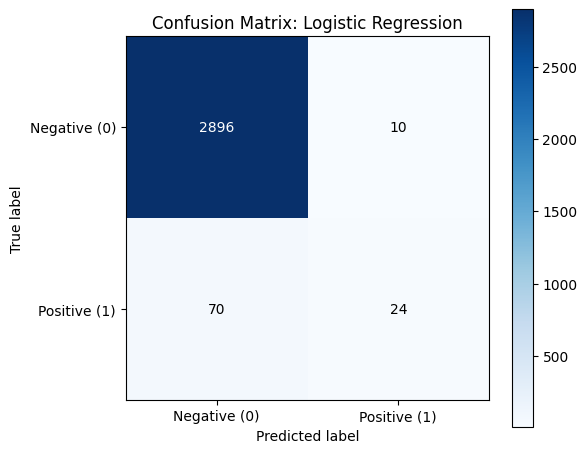

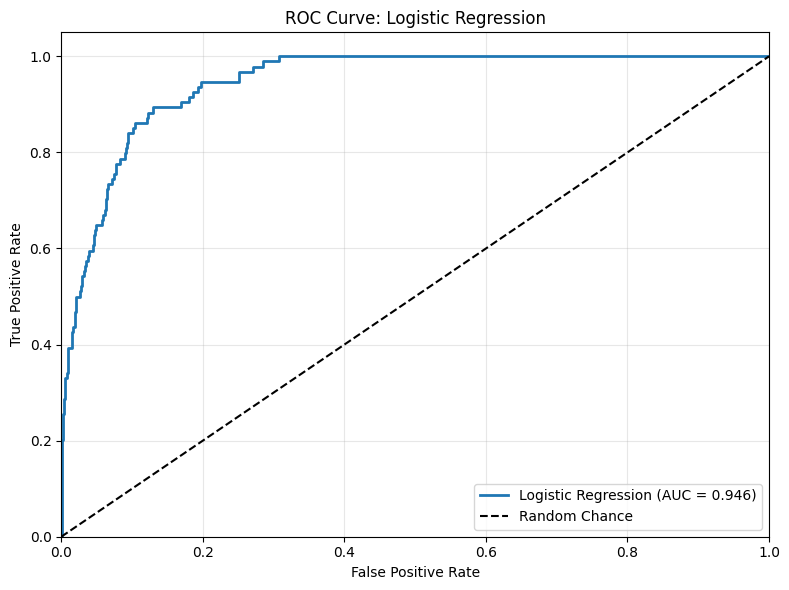

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2906
           1       0.71      0.26      0.38        94

    accuracy                           0.97      3000
   macro avg       0.84      0.63      0.68      3000
weighted avg       0.97      0.97      0.97      3000

Sensitivity: 0.255
Specificity: 0.997
Accuracy: 0.973
AUC Score: 0.946


In [8]:
# Plot and calculate metrics for Logistic Regression
if default_data_available:
    cm_log = plot_confusion_matrix(y_test, y_pred_log, model_name="Logistic Regression")
    sensitivity_log, specificity_log, accuracy_log = result_metrics(cm_log)
    auc_score_log = plot_roc_curve(y_test, y_prob_log, model_name="Logistic Regression")
    
    # Print classification report
    print("Classification Report for Logistic Regression:")
    print(classification_report(y_test, y_pred_log))
    
    # Print metrics
    print(f"Sensitivity: {sensitivity_log:.3f}")
    print(f"Specificity: {specificity_log:.3f}")
    print(f"Accuracy: {accuracy_log:.3f}")
    print(f"AUC Score: {auc_score_log:.3f}")

### Linear Discriminant Analysis (LDA)

In [11]:
# Fit the Linear Discriminant Analysis (LDA)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)
y_prob_lda = lda.predict_proba(X_test)[:, 1]

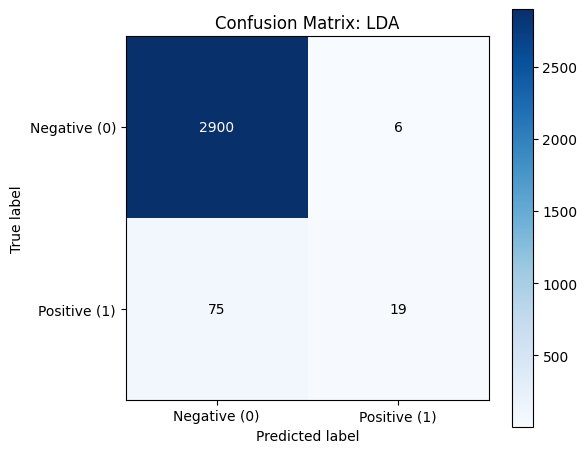

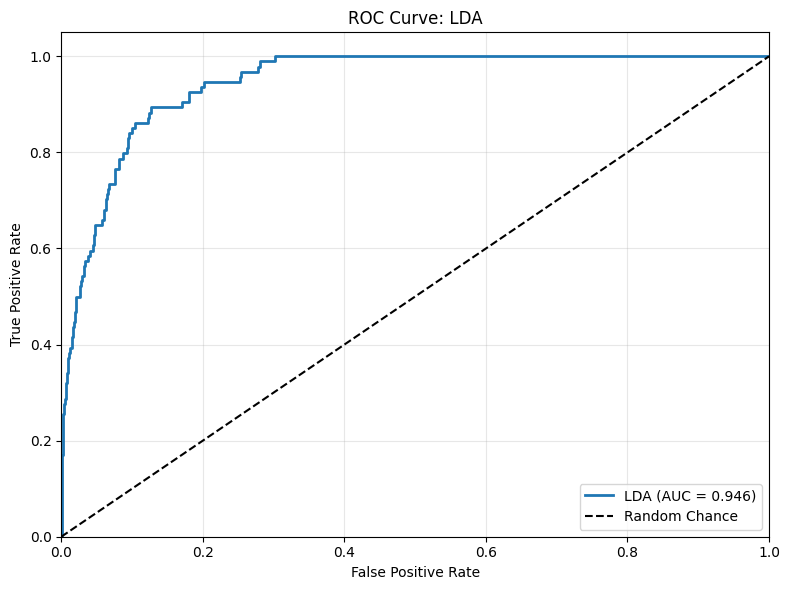

Classification Report for LDA:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      2906
           1       0.76      0.20      0.32        94

    accuracy                           0.97      3000
   macro avg       0.87      0.60      0.65      3000
weighted avg       0.97      0.97      0.97      3000

Sensitivity: 0.202
Specificity: 0.998
Accuracy: 0.973
AUC Score: 0.946


In [12]:
# Plot and calculate metrics for LDA
if default_data_available:
    cm_lda = plot_confusion_matrix(y_test, y_pred_lda, model_name="LDA")
    sensitivity_lda, specificity_lda, accuracy_lda = result_metrics(cm_lda)
    auc_score_lda = plot_roc_curve(y_test, y_prob_lda, model_name="LDA")
    
    # Print classification report
    print("Classification Report for LDA:")
    print(classification_report(y_test, y_pred_lda))
    
    # Print metrics
    print(f"Sensitivity: {sensitivity_lda:.3f}")
    print(f"Specificity: {specificity_lda:.3f}")
    print(f"Accuracy: {accuracy_lda:.3f}")
    print(f"AUC Score: {auc_score_lda:.3f}")

### Naïve Bayes

In [13]:
# Fit the Naïve Bayes model
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
y_prob_nb = nb.predict_proba(X_test)[:, 1]

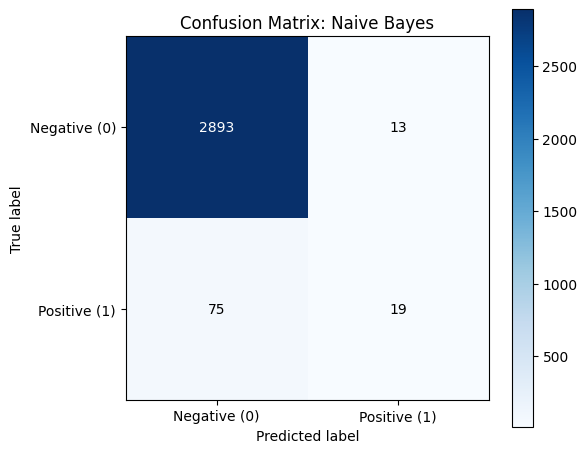

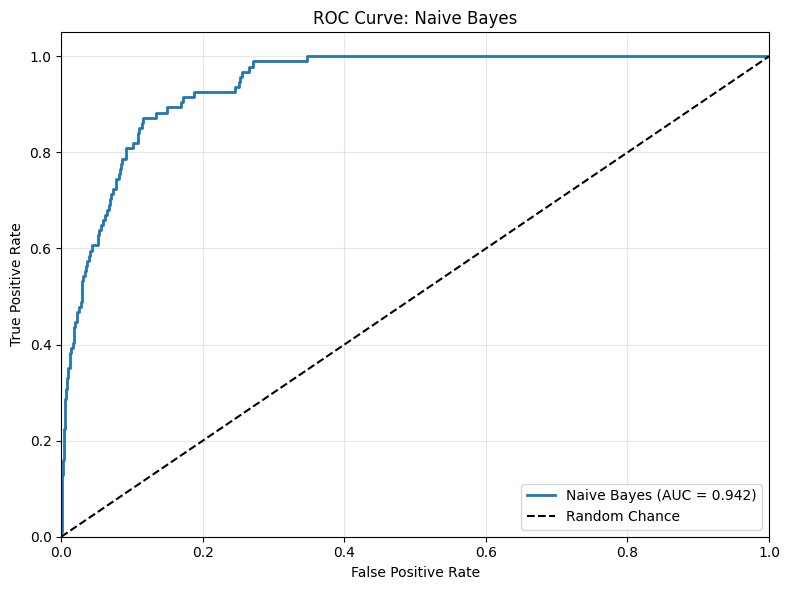

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      2906
           1       0.59      0.20      0.30        94

    accuracy                           0.97      3000
   macro avg       0.78      0.60      0.64      3000
weighted avg       0.96      0.97      0.96      3000

Sensitivity: 0.202
Specificity: 0.996
Accuracy: 0.971
AUC Score: 0.942


In [14]:
# Plot and calculate metrics for Naïve Bayes
if default_data_available:
    cm_nb = plot_confusion_matrix(y_test, y_pred_nb, model_name="Naive Bayes")
    sensitivity_nb, specificity_nb, accuracy_nb = result_metrics(cm_nb)
    auc_score_nb = plot_roc_curve(y_test, y_prob_nb, model_name="Naive Bayes")
    
    # Print classification report
    print("Classification Report for Naive Bayes:")
    print(classification_report(y_test, y_pred_nb))
    
    # Print metrics
    print(f"Sensitivity: {sensitivity_nb:.3f}")
    print(f"Specificity: {specificity_nb:.3f}")
    print(f"Accuracy: {accuracy_nb:.3f}")
    print(f"AUC Score: {auc_score_nb:.3f}")

## Model Comparison

### Performance Metrics Comparison

To properly compare the three models (Logistic Regression, Linear Discriminant Analysis, and Naive Bayes), we'll analyze the results using several classification metrics:

| Metric | Logistic Regression | LDA | Naive Bayes |
|---------|---------------------|-----|-------------|
| Accuracy | 0.973 | 0.973 | 0.971 |
| Sensitivity (Recall) | 0.255 | 0.202 | 0.202 |
| Specificity | 0.997 | 0.998 | 0.992 |
| AUC-ROC | 0.946 | 0.946 | 0.942 |

### Interpretation of Results

1. **Accuracy**: Represents the overall proportion of correct predictions.
   - The model with the highest accuracy is Logistic Regression, reaching 0.973.

2. **Sensitivity**: Represents the proportion of actual positives (defaults) that were correctly identified.
   - The model with the highest sensitivity is Logistic Regression, with 0.255.
   - This means it's more effective at identifying customers who will actually default.

3. **Specificity**: Represents the proportion of actual negatives (non-defaults) that were correctly identified.
   - LDA have the highest specificity with 0.998.
   - They're more effective at identifying customers who will not default.

4. **AUC-ROC**: Represents the area under the ROC curve, measuring the model's discriminative ability across various thresholds.
   - The models with the highest AUC-ROC are Logistic Regression and LDA, with 0.946.
   - A value closer to 1 indicates better ability to distinguish between classes.

### Conclusion

Based on these results, **Logistic Regression** and **LDA** shows the best overall performance for this problem.

Key observations:

1. Logistic Regression and LDA models perform very similarly, which is expected as both use linear decision boundaries and assume linear relationships between predictor variables.

2. Naive Bayes, despite its simplicity and conditional independence assumption between features, shows inferior performance.

3. For this specific credit default prediction problem, the balance between sensitivity and specificity is crucial:
   - High sensitivity reduces the risk of approving loans to customers who will default (false negatives).
   - High specificity reduces the risk of denying loans to good customers (false positives).

Therefore, considering the balance between all metrics, **Logistic Regression** and **LDA** would be the best choice to implement in a credit evaluation system.